In [1]:
import numpy as np
import json
import sys
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *

### etl (new readfilerun and gen)

In [3]:
def readfilerun(run_, output_dir):
    names = listdir('data2') # all filenames in data
    daneruns = [x for x in names if not 'losslog' in x]
    # daneruns = ['data/20220116T055105_20-100-true-20-100-iperf.csv', 'data/20220116T055942_20-250-true-20-250-iperf.csv']
    losslogs = [x for x in names if 'losslog' in x]
    
    for run in daneruns:
        # print(run) #for debug
        
        run_labels = run.split('_')[1].split('-')[:-1]
        
        temp_label_str = '-'.join(run_labels) 
        losslog = f'data2/losslog-{temp_label_str}.csv' #losslog filename str
        
        run_df = pd.read_csv(f'data2/{run}')
        losslog_df = pd.read_csv(losslog, header=None).rename(
            columns={0:'event', 1:'drop_unix', 2:'IP1', 3:'Port1', 4:'IP2', 5:'Port2', 6:'Proto'})
        losslog_df['Time'] = losslog_df['drop_unix'].astype(int)
        df = pd.merge(run_df, losslog_df, on=['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto'], how="left") # merge on fivetuple key
        # df.fillna(inplace=True, value=-1) #TODO plan implementation of dealing with null values
        # df['event'] =  # TODO change to 3 different profiles: no drop, drop, and switch event
        df = df[df['Proto'] == df['Proto'].mode()[0]] # selects relevant non ipv6 int(connection
        
        ## adding labels
        df['latency'] = int(run_labels[0])
        df['loss'] = int(run_labels[1])
        df['later_latency'] = int(run_labels[3])
        df['later_loss'] = int(run_labels[4])
        df['deterministic'] = bool(run_labels[2])
        
        #TODO future implementation of boolean flag for when the switch happens so we know when to use later lat/loss
        
        df.to_csv(f'{output_dir}/labeled-from-{run_}_{temp_label_str}.csv') # save to temporary output directory: just merging takes a bit

In [4]:
def gen(cond , subset):
    unseen = ""
    if cond == 'seen': 
        print("transforming seen data")
    if cond == 'unseen': 
        print("transforming un seen data")
        unseen = "unseen"
    tempdatafiles = listdir('tempdata')
    
    print("CAT")
#     partitions = np.array_split(tempdatafiles, 10)
    
#     for count, i in enumerate(partitions): 
#         gen_helper(count, i, subset, unseen)
#         print("PARTITION " + str(count) + " FINISHED!")
    
    dir2 = listdir('outputs/gen_temp')
    c_all = [x for x in dir2 if 'all' in x]
    c_subset = [x for x in dir2 if 'subset' in x]
    c_t = [x for x in dir2 if 'transform' in x]
    
    path = os.path.join(os.getcwd() , "outputs", "gen_temp")
    path2 = os.path.join(os.getcwd() , "outputs")
    
    data_i, datasubset_i, transformed_i  = [], [], []
    for i in range(len(c_all)): 
        temp1 = pd.read_csv( os.path.join(path, c_all[i]))
        data_i.append(temp1)
        temp2 = pd.read_csv( os.path.join(path, c_subset[i]))
        datasubset_i.append(temp2)
        temp3 = pd.read_csv( os.path.join(path, c_t[i]))
        transformed_i.append(temp3)
        
    combined_data = pd.concat(data_i , ignore_index=True)#.reset_index(drop = True)
    combined_data.to_csv(os.path.join(path2, unseen + "combined_all.csv"), index = False)
    
    combined_subset = pd.concat(datasubset_i , ignore_index=True)
    combined_subset.to_csv(os.path.join(path2, unseen +  "combined_subset_6068.csv"), index = False)
    
    combined_t = pd.concat(transformed_i, ignore_index=True)  
    combined_t.to_csv(os.path.join(path2, unseen +  "combined_transform.csv"), index = False)
    
    return None

In [5]:
def gen_helper(ct, file_lst, subset, unseen):
    """ """
    data, datasubset, transformed  = [], [], []
    for j in file_lst:
        loc = os.path.join(os.getcwd(), "tempdata", j)
        print(loc)
        df_cols = genfeat(pd.read_csv(loc))
        
        #data
        time_scaled = time(df_cols)
        data.append(time_scaled)
        
        #subset
        df_mid = time_scaled.iloc[60:60+subset]
        datasubset.append(df_mid)

        #transformed
        f_df = agg10(df_cols)
        transformed.append(f_df)

    path = os.path.join(os.getcwd() , "outputs", "gen_temp")

    temp_data = pd.concat(data , ignore_index=True)#.reset_index(drop = True)
    temp_data.to_csv(os.path.join(path, unseen + "temp_all_" + str(ct) + ".csv"), index = False)
    
    temp_subset = pd.concat(datasubset , ignore_index=True)
    temp_subset.to_csv(os.path.join(path, unseen +  "temp_subset_6068_" + str(ct) + ".csv"), index = False)
    
    temp_t = pd.concat(transformed, ignore_index=True)  
    temp_t.to_csv(os.path.join(path, unseen +  "temp_transform_" + str(ct) + ".csv"), index = False)

#### eda

In [6]:
def main_eda(cond, lst, filen1, filen2, filen3):
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    
    fpath1 = os.path.join(os.getcwd() , "outputs", unseen + filen1)
    df_1 = pd.read_csv(fpath1)
    fpath2 = os.path.join(os.getcwd() , "outputs", unseen + filen2)
    df_2 = pd.read_csv(fpath2)
    fpath3 = os.path.join(os.getcwd() , "outputs", unseen + filen3)
    df_3 = pd.read_csv(fpath3)
    
    plottogether(cond, lst, df_1, filen1.strip(".csv")) # trends over subset
    plottogether(cond, lst, df_3, filen3.strip(".csv")) # trends over entire data
    plotloss(cond, df_2)

    plot_correlation_matrix(cond, df_2) # correlation matrix
    plotlongest(df_3, cond)
    # below makes rest of visualizations
    plotbytes(df_3)
    #plot_detailed_bytes()

In [7]:
def plot_detailed_bytes(df):
    ax = plt.figure(figsize=(18,8))
    df['1->2Bytes'].plot(title='1->2Bytes/s Rate')
    plt.axvline(x=180, color='r')
    for i in df[df['event'] == 'drop'].index:
        plt.axvline(x=i, color='y', alpha=.45)
    custom_lines = [Line2D([0], [0], color='b', lw=2),
        Line2D([0], [0], color='y', lw=2, alpha=0.45),
        Line2D([0], [0], color='r', lw=2)]
    plt.legend(custom_lines, ['Bytes per Second', 'Packet drop', '180s mark'], loc='upper right', framealpha=1);

In [8]:
# overlaying model predictions and plotting detailed bytes

#### train

In [9]:
def test_feat(cond, df, cols, p, df_u): 
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    # col is feauture comb
    # p is for loss or latency   1: loss  # 2 : latency
    X = df[cols]
    X2 = df_u[cols]

    if p == 1: 
        y = df.loss
        y2 = df_u.loss
    if p == 2: 
        y = df.latency
        y2 = df_u.latency
        
    # randomly split into train and test sets, test set is 80% of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)

    if unseen == 'unseen': 
        X_test = X2
        y_test = y2
    
    clf = DecisionTreeRegressor()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc1 = mean_squared_error(y_test, y_pred)
    
    clf2 = RandomForestRegressor(n_estimators=10)
    clf2 = clf2.fit(X_train,y_train)
    y_pred2 = clf2.predict(X_test)
    acc2= mean_squared_error(y_test, y_pred2)
    #print("Random Forest Accuracy:", acc2, '\n')
    
    clf3 = ExtraTreesRegressor(n_estimators=10)
    clf3 = clf3.fit(X_train,y_train)
    y_pred3 = clf3.predict(X_test)
    acc3= mean_squared_error(y_test, y_pred3)
    #print("Extra Trees Accuracy:", acc3, '\n')
    
    pca = PCA() 
    X_transformed = pca.fit_transform(X_train) 
    cl = DecisionTreeRegressor() 
    cl.fit(X_transformed, y_train)
    newdata_transformed = pca.transform(X_test)
    y_pred4 = cl.predict(newdata_transformed)
    acc4 = mean_squared_error(y_test, y_pred4)
    #print("PCA Accuracy:", acc4, '\n')
    
    clf_gbc = GradientBoostingRegressor(random_state=0)
    clf_gbc.fit(X_train, y_train)
    y_pred5 = clf_gbc.predict(X_test)
    acc5 = mean_squared_error(y_test, y_pred5)
    return [acc1, acc2, acc3, acc4, acc5 ]




def test_mse(cond, all_comb1, all_comb2):
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    filedir_unseen = os.path.join(os.getcwd(), "outputs", unseen + "combined_t.csv")
    df_unseen = pd.read_csv(filedir_unseen)
    filedir = os.path.join(os.getcwd(), "outputs", "combined_t.csv")
    df = pd.read_csv(filedir)
    
    all_comb1 = pd.Series(all_comb1).apply(lambda x: list(x))
    all_comb2 = pd.Series(all_comb2).apply(lambda x: list(x))
    dt = []
    rf = []
    et = []
    pca = []
    gbc = []
    for i in all_comb1:
        acc_loss = test_feat(cond, df, i, 1, df_unseen)
        dt.append(acc_loss[0])
        rf.append(acc_loss[1])
        et.append(acc_loss[2])
        pca.append(acc_loss[3])
        gbc.append(acc_loss[4])

    dt2 = []
    rf2 = []
    et2 = []
    pca2 = []
    gbc2 = []
    for i in all_comb2:
        # 1 = loss
        # 2 = latency
        acc_latency = test_feat(cond, df, i, 2, df_unseen)
        #print(accs)
        dt2.append(acc_latency[0])
        rf2.append(acc_latency[1])
        et2.append(acc_latency[2])
        pca2.append(acc_latency[3])
        gbc2.append(acc_latency[4])
    
    dict1 = pd.DataFrame({'feat': all_comb1, 'dt': dt, 'rf': rf, 'et': et, 'pca': pca, 'gbc': gbc})
    dict2 = pd.DataFrame({'feat2': all_comb2, 'dt2': dt2, 'rf2': rf2, 'et2': et2, 'pca2': pca2, 'gbc2': gbc2})
    
    #feat_df = pd.concat([dict1, dict2], axis=1).drop(['feat2'], axis=1)
    path = os.path.join(os.getcwd() , "outputs")
    dict1.to_csv(os.path.join(path, unseen + "feat_df1.csv"), index = False)
    dict2.to_csv(os.path.join(path, unseen + "feat_df2.csv"), index = False)
    
    # return feat_df

def best_performance(cond):
    unseen = ''
    if cond == 'unseen': 
        unseen = 'unseen'
    #print("finding best loss performance")
    filedir1 = os.path.join(os.getcwd(), "outputs", unseen + "feat_df1.csv")
    df1 = pd.read_csv(filedir1)
    print( "\n")
    print("Loss Performance sorted from lowest to highest", "\n")
    print(df1.sort_values(by=['dt', 'rf', 'et', 'pca'], ascending = True)[:5], "\n")
    #print("Loss Performance sorted from highest to lowest")
    #print(df1.sort_values(by=['dt', 'rf', 'et', 'pca'], ascending = False)[:5])
    

    #print("finding best latency performance")
    filedir2 = os.path.join(os.getcwd(), "outputs", unseen + "feat_df2.csv")
    df2 = pd.read_csv(filedir2)
    print( "\n")
    print("Latency Performance sorted from lowest to highest", "\n")
    print(df2.sort_values(by=['dt2', 'rf2', 'et2', 'pca2'], ascending = True)[:5], "\n")
    #print("Latency Performance sorted from highest to lowest")
    #print(df2.sort_values(by=['dt2', 'rf2', 'et2', 'pca2'], ascending = False)[:5])
    
    #combined.to_csv("combined_latency.csv")
    # sorted.to_csv(os.path.join(path, "sorted_df.csv"), index = False)


#### main

In [10]:
def main(targets):

    transform_config = json.load(open('config/transform.json'))
    columns = json.load(open('config/columns.json'))
    eda_config = json.load(open('config/eda.json'))
    all_config = json.load(open("config/all.json"))

    test_unseen = 'unseen'
    test_seen = 'seen'
    
    cond1 = True
    cond2 = False

    if 'data' in targets:
        """generating feat from unseen and seen data"""
#         readfilerun('data2', 'tempdata') 
        gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)

    if 'eda' in targets:  
#         readfilerun('data2', 'tempdata') 
#         gen(test_seen, **transform_config)
        main_eda(test_seen, **eda_config)
        print("EDA saved to outputs/eda/ folder")

    if 'train' in targets:
        "trains tests in this target"
#         readfilerun('data2', 'tempdata') 
#         gen(test_seen, **transform_config)
                
        comb1 = getAllCombinations(1)
        comb2 = getAllCombinations(2)
        
        print("Testing on seen data: ")
        test_mse(test_seen, comb1, comb2)
        best_performance(test_seen)
                        
    if "inference" in targets: 
        print('tba')
#         readfilerun('data2', 'tempdata') 
#         gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)
        
#         comb1 = getAllCombinations(1)
#         comb2 = getAllCombinations(2)
        
#         print("Testing on unseen data: ")
#         test_mse(test_unseen, comb1, comb2)
#         best_performance(test_unseen)
            
    if "test" in targets: 
        """ runs all targets on sample data"""
        print('tba')
#         readfilerun('data2', 'tempdata') 
#         gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)
        
#         main_eda(test_seen, **eda_config)
#         print("EDA saved to outputs/eda/ folder")
        
#         comb1 = getAllCombinations(1)
#         comb2 = getAllCombinations(2)
        
#         print("Testing on seen data: ")
#         test_mse(test_seen, comb1, comb2)
#         best_performance(test_seen)
        
#         print("Testing on unseen data: ")
#         test_mse(test_unseen, comb1, comb2)
#         best_performance(test_unseen)
        
    if 'all' in targets: 
        print('tba')
        
# if __name__ == '__main__':

#     targets = sys.argv[1:]
#     main(targets)

In [11]:
targets = ['data', 'eda', 'train', 'inference', 'test', 'all']
# main(targets[0])

end of main4
end of main4
EDA saved to outputs/eda/ folder


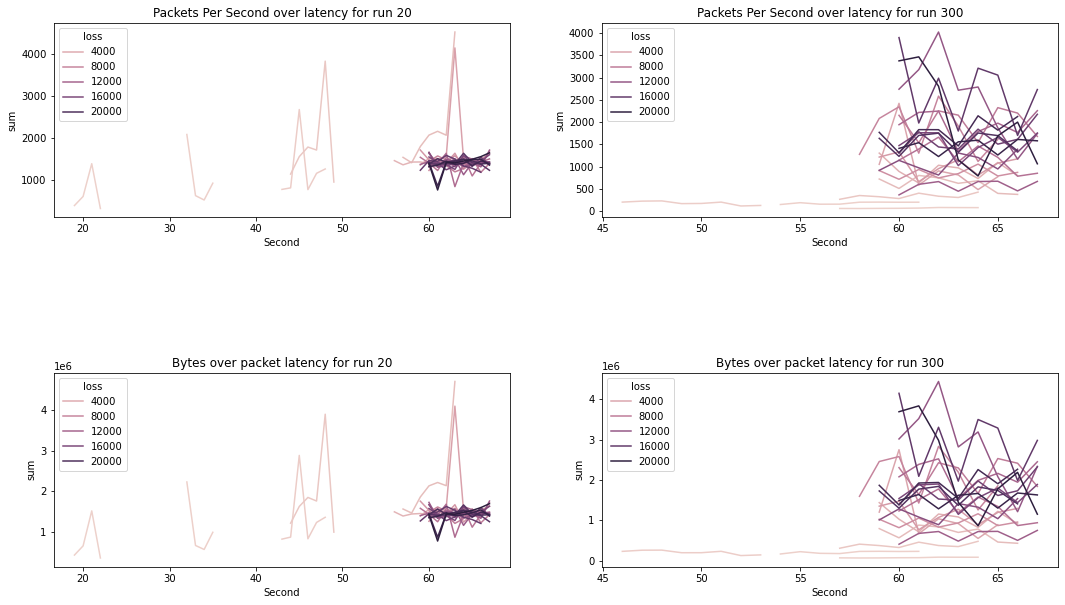

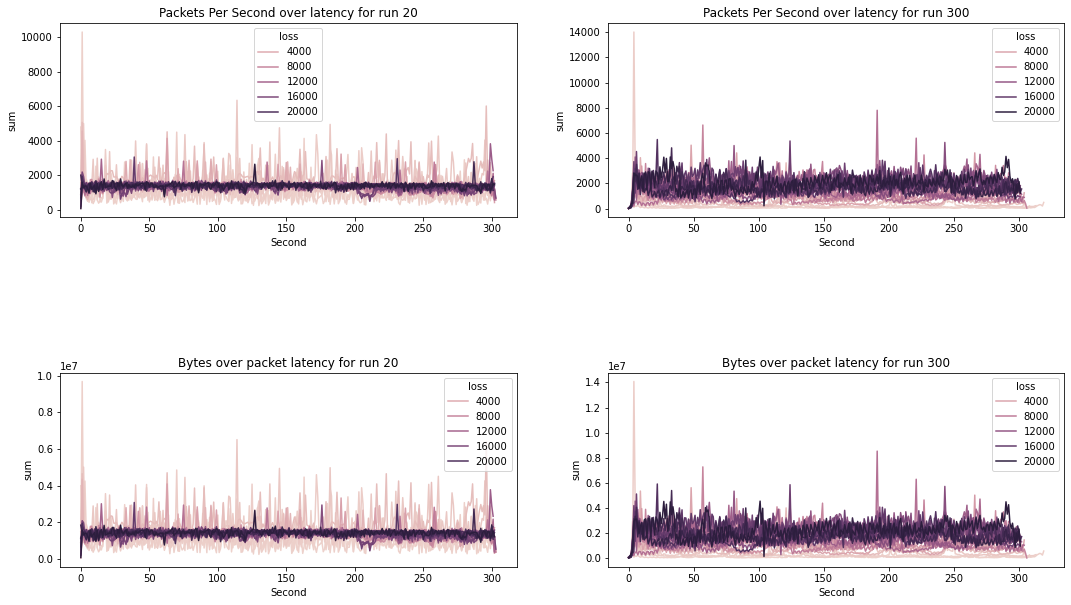

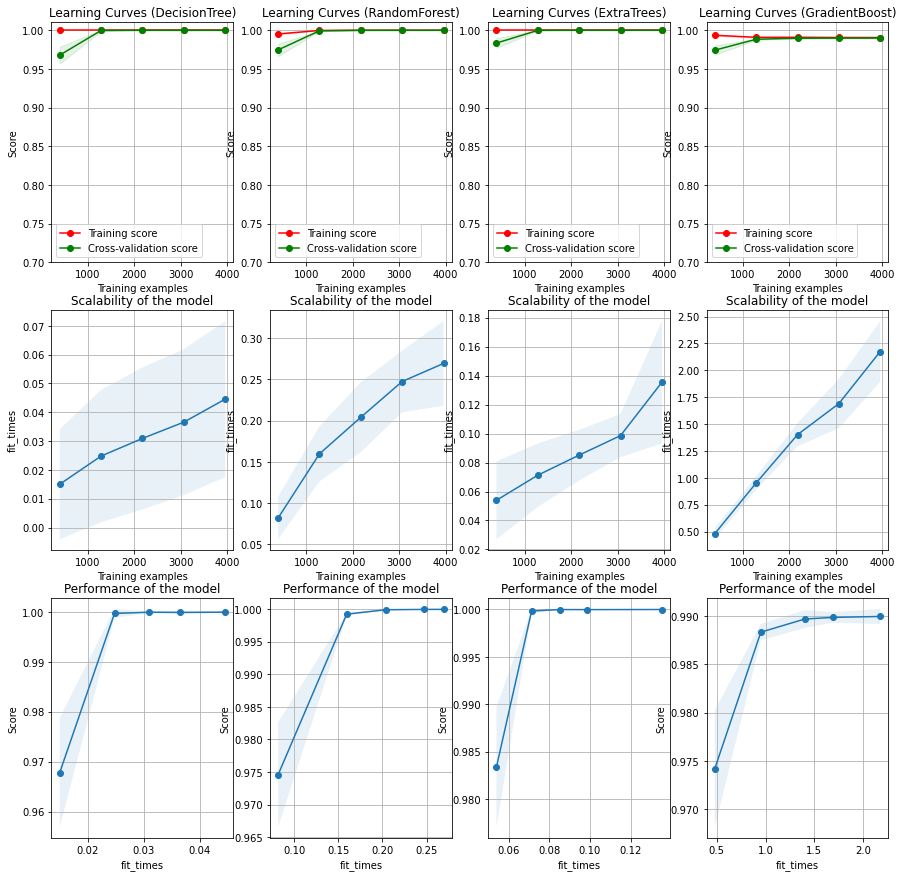

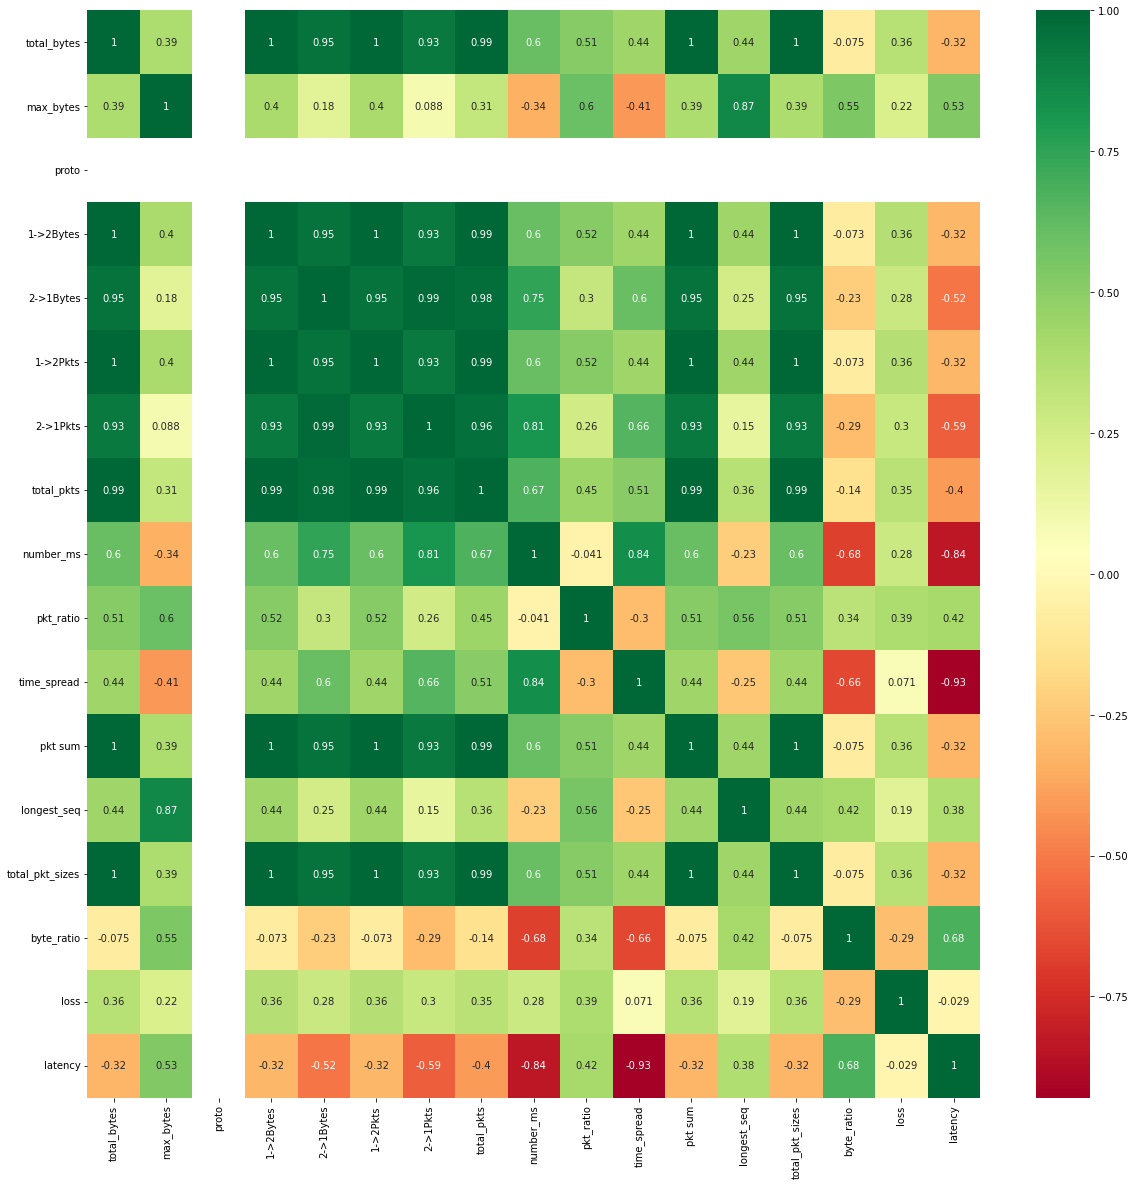

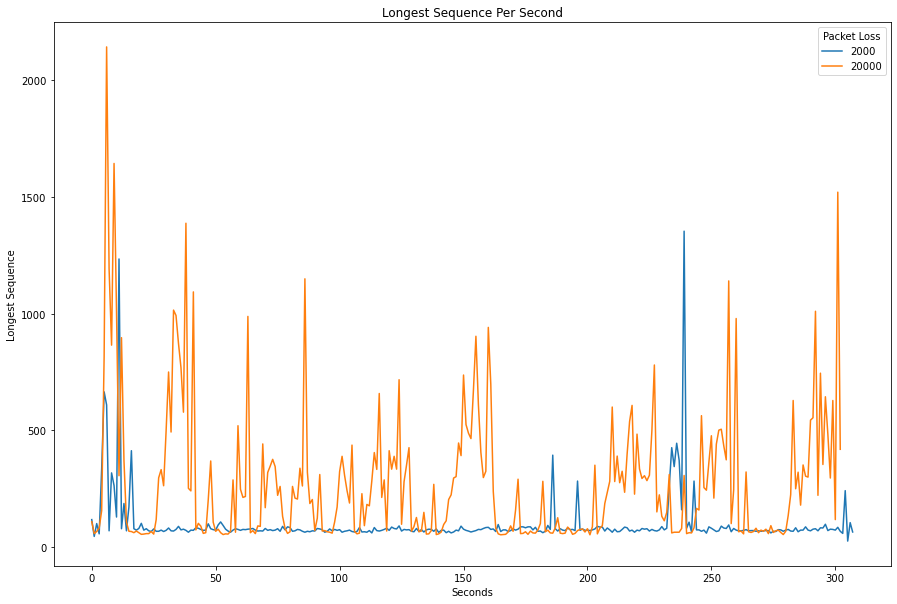

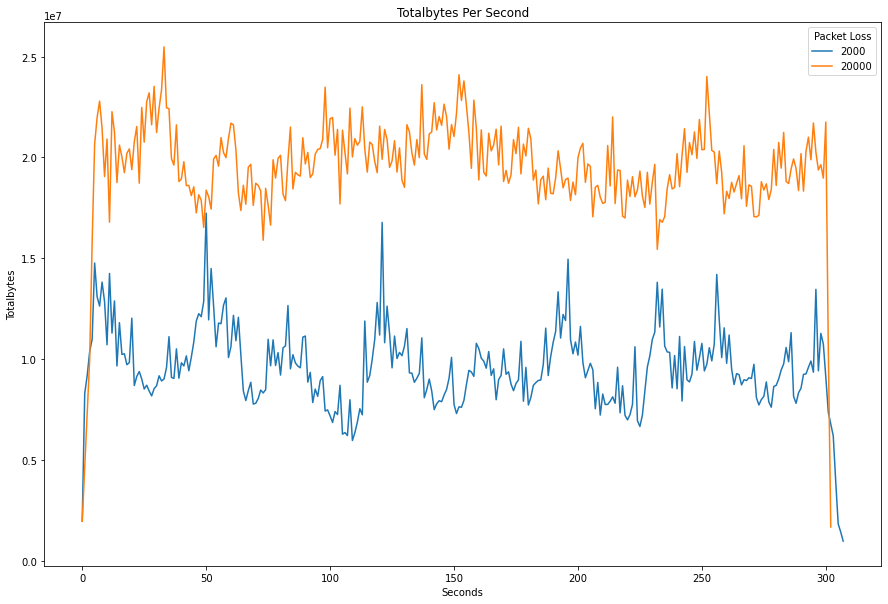

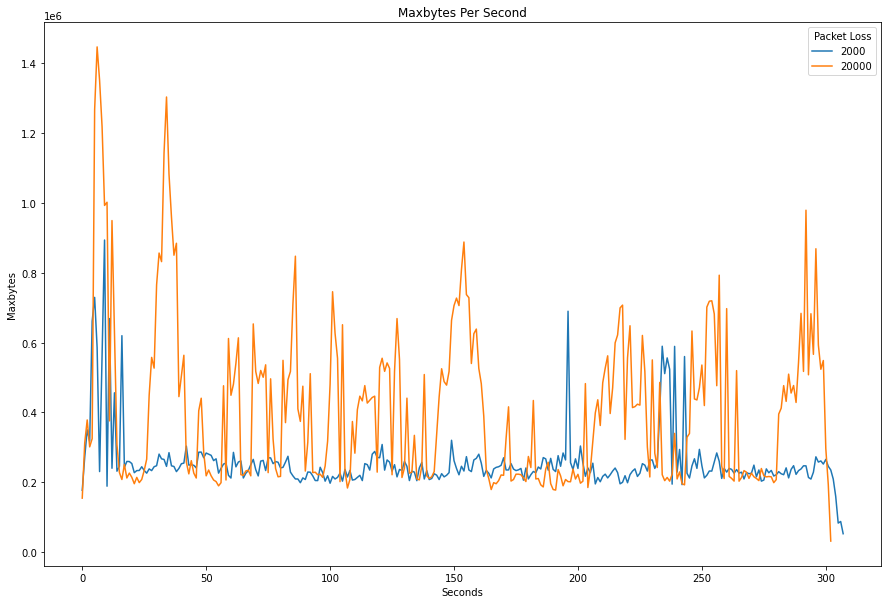

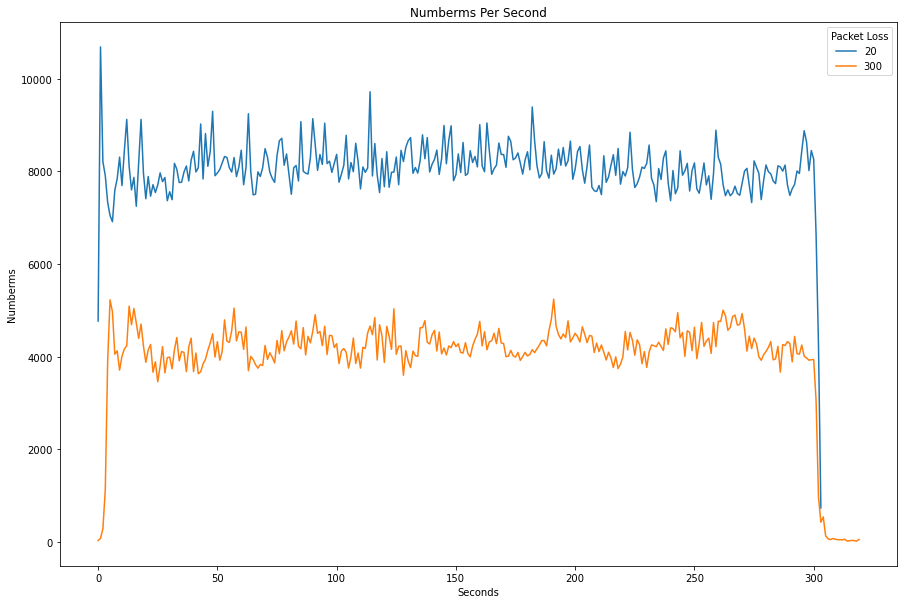

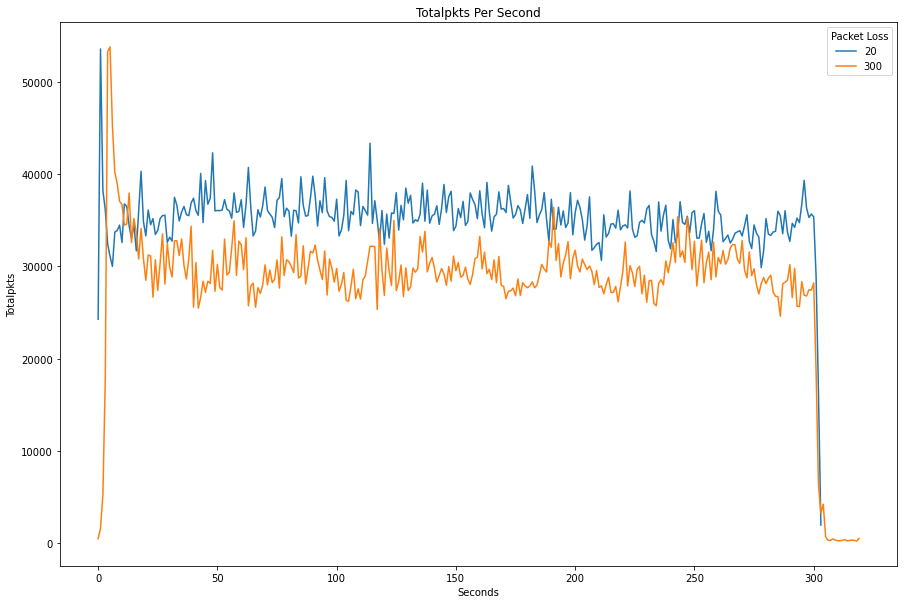

In [12]:
main(targets[1])